VERSION 4: LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
min_transactions = 200

N = 10 #number of pre-transactions used for predict initial : 10
length = 20
num_of_items = 57 
NUL_ID = num_of_items - 1
time_slot = 24*60*60*1000 #1 day
time_slot

86400000

In [ ]:
RAWDATA_PATH = '/content/gdrive/MyDrive/NCKH/E-commerce/rawdata.csv'
HASH_FILE_PATH = '/content/gdrive/MyDrive/NCKH/E-commerce/hash_table.csv'
NEW_DATA_PATH = '/content/gdrive/MyDrive/NCKH/E-commerce/UserMoreThan200Trans.csv'
WEIGHTS_PATH = '/content/gdrive/MyDrive/NCKH/E-commerce/lstm_v4.hdf5'

In [ ]:
#load proceessed data
df = pd.read_csv(RAWDATA_PATH)
df_hash = pd.read_csv(HASH_FILE_PATH)

temp = zip(df_hash.itemID,df_hash.hash_value)
hash_itemID = dict(temp)

temp = zip(df_hash.hash_value,df_hash.itemID)
reverse_hash_itemID = dict(temp)

# Prepare data

Note: Ignore "Load data", "Ignore user" if you use processed data

## Load data, convert to dataframe

In [ ]:
df = pd.read_csv(RAWDATA_PATH)
df.head()

In [ ]:
hash_itemID = {}
idx = 0
for itemID in set(df.itemID):
  hash_itemID[itemID] = idx
  idx += 1

In [ ]:
with open(HASH_FILE_PATH,'w') as f:
  f.write('itemID,hash_value\n')
  for item in hash_itemID:
    f.write(f'{item},{hash_itemID[item]}\n')

In [ ]:
reverse_hash_itemID = {hash_itemID[i]:i for i in hash_itemID}

## Generate time series data

In [ ]:
import math

start_time = min(df.timestamp)
end_time = max(df.timestamp)
num_of_slots = math.ceil((end_time-start_time)/time_slot)
start_time,end_time,num_of_slots

(1604163797349, 1619801952751, 181)

### generate

In [ ]:
lst_user = list(set(df.userID))
len(lst_user)

306

In [ ]:
import more_itertools as mit
from google.colab import output
from functools import reduce
countItems = list()
for userID in lst_user:
  subUser = df[df.userID == userID]
  # print(len(set(subUser.itemID)))
  countItems.append(len(subUser.itemID))

print('---------------')
print(max(countItems))
print(min(countItems))
avgItemLs = list()
print(lst_user[0])
def flatten(x):
  #[[1],[2,1,3],[2]] -> [1,2,1,3,2]
  return [str(i) for c in x for i in c]
X_item2vec = []
for user in lst_user:
  subdf = df[df.userID == user]
  idx = ((subdf.timestamp - start_time) // time_slot).to_numpy()[:-1]
  itemIDs = list(map(lambda x: hash_itemID[x],subdf.itemID))[:-1]
  series = [[] for _ in range(num_of_slots)]
  for id,itemID in zip(idx,itemIDs):
    series[id].append(itemID)
  #print(series)
  temp = list(mit.windowed(series, n=length, step=1))[:-1]  
  new_row = list(map(flatten,temp))
  X_item2vec.extend(new_row)
  #print(X_item2vec)
  lenItem = list()
  for item in X_item2vec:
    lenItem.append(len(item))
  #print(max(lenItem))
  #print(min(lenItem))

  SetNItems = list(set(lenItem))
  #print(len(SetNItems))
  probItems = list()
  freqItems = list()
  for nItem in SetNItems:
    freqItems.append(lenItem.count(nItem))
    probItems.append(np.round(lenItem.count(nItem)/len(lenItem), 4))
  avgNItems = 0
  for prob, item in zip(probItems, SetNItems):
    avgNItems += (prob * item)
  #print(SetNItems)
  #print(freqItems)
  #print(probItems)
  #print(avgNItems)
  N = int(np.round(avgNItems))
  #print(N)
  avgItemLs.append(N)


---------------
826
201
2f58e63ca489ed90f26c5e9d1ecbe01510221
[27, 25, 30, 31, 32, 31, 30, 30, 31, 31, 30, 35, 35, 33, 33, 34, 34, 33, 33, 33, 33, 33, 33, 33, 31, 31, 31, 33, 33, 33, 33, 33, 33, 33, 34, 33, 33, 34, 34, 34, 34, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 32, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 31, 32, 32, 32, 32, 31, 31, 32, 32, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 3

In [ ]:
avgItem = list(set(avgItemLs))
print(avgItemLs)
#print(len(SetNItems))
probItems = list()
freqItems = list()
for nItem in avgItem:
  freqItems.append(avgItemLs.count(nItem))
  probItems.append(np.round(avgItemLs.count(nItem)/len(avgItemLs), 4))
avgNItems = 0
for prob, item in zip(probItems, avgItem):
  avgNItems += (prob * item)
print(avgNItems)

[27, 25, 30, 31, 32, 31, 30, 30, 31, 31, 30, 35, 35, 33, 33, 34, 34, 33, 33, 33, 33, 33, 33, 33, 31, 31, 31, 33, 33, 33, 33, 33, 33, 33, 34, 33, 33, 34, 34, 34, 34, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 32, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 31, 32, 32, 32, 32, 31, 31, 32, 32, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 30, 30,

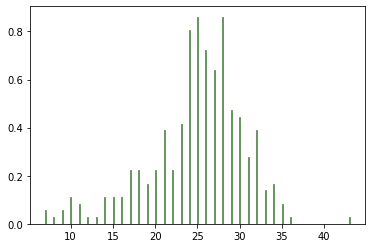

In [ ]:
import matplotlib.pyplot as plt
plt.hist(np.array(countItems), bins= len(lst_user),  density= True, stacked=True, edgecolor="#6A9662", color="#DDFFDD")
plt.show()

In [ ]:
import more_itertools as mit
from google.colab import output
from functools import reduce
X_item2vec = []
X = []
y = []

is_exists = np.zeros(num_of_items,)

def onehot(x):
  #x: int
  lst = [0]*num_of_items
  lst[x] = 1
  return lst

def removeNul(x):
  #(1,2,-1,3,-1,2) -> (1,2,3,2)
  res = []
  return [str(i) for i in x if (i != -1)]

def flatten(x):
  #[[1],[2,1,3],[2]] -> [1,2,1,3,2]
  return [str(i) for c in x for i in c]
ExpectedItemOfEachUser = list()
for userID in lst_user:
  subdf = df[df.userID == userID]

  # train_data for Item2Vec
  idx = ((subdf.timestamp - start_time) // time_slot).to_numpy()[:-1]
  itemIDs = list(map(lambda x: hash_itemID[x],subdf.itemID))[:-1]
  series = [[] for _ in range(num_of_slots)]
  for id,itemID in zip(idx,itemIDs):
    series[id].append(itemID)

  temp = list(mit.windowed(series, n=length, step=1))[:-1]  
  new_row = list(map(flatten,temp))
  X_item2vec.extend(new_row)
  '''
  nItemEachLengthDay = list()
  for lsItem in X_item2vec:
    nItemEachLengthDay.append(len(lsItem))
  SetNItems = list(set(nItemEachLengthDay))
  probNItems = list()
  freqNItems = list()
  for nItem in SetNItems:
    freqItems.append(nItemEachLengthDay.count(nItem))
    probItems.append(np.round(nItemEachLengthDay.count(nItem)/len(lenItem), 4))
  avgNItems = 0
  for prob, item in zip(probItems, SetNItems):
    avgNItems += (prob * item)
  ExpectedItemOfEachUser.append(int(np.round(avgNItems)))'''
nItem = list()
for item in X_item2vec:
  nItem.append(len(item))
print(nItem)

[18, 17, 17, 18, 21, 19, 21, 20, 21, 19, 21, 22, 22, 21, 21, 23, 26, 28, 29, 30, 30, 31, 28, 30, 32, 32, 30, 28, 27, 26, 24, 29, 32, 32, 33, 35, 33, 36, 41, 41, 41, 39, 40, 37, 32, 34, 35, 37, 37, 41, 41, 35, 38, 38, 37, 33, 33, 27, 22, 22, 22, 22, 21, 21, 21, 20, 22, 22, 23, 24, 27, 33, 27, 29, 29, 29, 26, 26, 25, 31, 32, 33, 33, 39, 39, 37, 38, 36, 37, 32, 29, 23, 23, 25, 26, 28, 30, 30, 34, 28, 28, 30, 31, 25, 27, 27, 23, 23, 22, 22, 22, 22, 24, 20, 23, 21, 19, 19, 15, 14, 13, 10, 11, 11, 11, 14, 16, 17, 17, 20, 20, 20, 20, 20, 16, 16, 20, 20, 20, 23, 23, 26, 25, 26, 24, 21, 19, 18, 17, 14, 15, 31, 34, 40, 40, 45, 42, 46, 46, 45, 45, 10, 9, 11, 9, 12, 18, 19, 17, 18, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 28, 28, 28, 30, 30, 25, 19, 18, 23, 24, 23, 23, 23, 28, 32, 35, 35, 38, 38, 40, 33, 41, 41, 35, 35, 35, 36, 37, 32, 30, 30, 32, 32, 28, 35, 37, 37, 34, 34, 33, 32, 24, 24, 23, 23, 23, 22, 21, 27, 31, 31, 29, 28, 34, 24, 22, 24, 25, 25, 24, 24, 25, 25, 25, 25, 25, 25, 25, 19, 15, 1

In [ ]:
print(X_item2vec[-10:-1])

[[], [], [], [], [], [], [], [], []]


In [ ]:
print(ExpectedItemOfEachUser)
avgItemLs = list(set(ExpectedItemOfEachUser))
probItems = list()
freqItems = list()
for nItem in avgItemLs:
  freqItems.append(ExpectedItemOfEachUser.count(nItem))
  probItems.append(np.round(ExpectedItemOfEachUser.count(nItem)/len(ExpectedItemOfEachUser), 4))
N = 0
for prob, item in zip(probItems, avgItemLs):
  N += (prob * item)
print(N)

[15, 9, 6, 6, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 

In [ ]:
for userID in lst_user:
  subdf = df[df.userID == userID]
  
  # data for MLP
  history = list(map(lambda x: hash_itemID[x],subdf.itemID))
  new_x = list(mit.windowed(history, n=N, step=1))[:-1]
  X.extend(new_x)
  y.extend(list(map(onehot,history[N:])))

In [ ]:
from gensim.models import Word2Vec
#CBOW model
vecs = Word2Vec(X_item2vec, min_count=1, size=20, window=5, sg=0)

In [ ]:
vecs['31']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-1.7457983 , -0.03775353,  2.8425977 ,  0.15785815,  0.69675505,
       -0.87709457, -1.1710693 ,  1.1394426 , -1.3282185 ,  1.1399964 ,
        0.65870893,  0.99542797, -0.6537868 ,  0.74891675,  0.12768298,
        0.62370014, -4.52984   ,  2.4132779 , -2.4517884 ,  0.58210504],
      dtype=float32)

In [ ]:
vecs.similar_by_vector(vecs['31'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """Entry point for launching an IPython kernel.


[('31', 0.9999998807907104),
 ('28', 0.7028887867927551),
 ('22', 0.6685466170310974),
 ('52', 0.5689590573310852),
 ('16', 0.5315408110618591),
 ('36', 0.5069469213485718),
 ('40', 0.41947466135025024),
 ('10', 0.4165197014808655),
 ('29', 0.3621065020561218),
 ('5', 0.35226738452911377)]

#### split train-test

In [ ]:
def mapping(x):
  #x = (1,2,3) -> (vect(1),vect(2),vect(3))
  return [vecs[str(i)] for i in x]

In [ ]:
X0 = np.array(list(map(mapping,X)))
y = np.array(y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X0, y, test_size=0.3)

In [ ]:
print(X_train[0],y_train[0],sep='\n')

[[ 6.5129924e-01  1.6419084e+00  3.5377438e+00 -3.0602694e+00
   1.6575816e+00  3.6499135e+00 -1.0681156e+00 -7.8784579e-01
   3.8557856e+00  1.4703530e-01  8.5361379e-01 -5.2849140e+00
  -3.5444936e-01  1.8827081e+00 -2.9449320e+00  1.9115125e+00
  -1.1883492e+00 -2.0477867e+00  1.9569786e+00  1.7436497e+00]
 [-6.8043065e-01 -6.1624227e-03  1.6263729e+00  1.2645227e+00
  -4.1074511e-01 -1.6922294e+00 -3.1108577e+00  8.1080443e-01
  -1.0110903e+00  3.0950842e-02  1.1936790e+00 -5.0448215e-01
  -8.7346762e-01 -5.4123276e-01  1.6905203e+00  1.1139882e+00
  -2.2435212e+00  6.2098289e-01 -1.1644461e+00 -1.0124084e+00]
 [ 4.1464096e-01 -1.0034333e+00  2.3616309e+00  1.0853826e+00
  -2.5790081e+00 -2.1498463e+00 -1.8840244e+00 -3.9800146e-01
   6.1340570e-01 -1.1553806e+00  5.8730545e+00  2.9448285e+00
  -7.1216232e-01  4.4435763e+00  2.4483128e+00 -3.0070722e+00
  -1.6423813e+00 -1.7905828e+00 -1.9727504e+00 -1.1270982e+00]
 [ 1.8253956e+00  2.6412027e+00  1.5689658e+00  9.8650277e-01
   2.

In [ ]:
X_train.shape

(57289, 10, 20)

# LSTM

In [ ]:
import numpy as np 
import os
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:


model = Sequential()

model.add(InputLayer((N,20)))
model.add(LSTM(N, activation= 'relu'))
model.add(Dense(num_of_items, activation='softmax'))

model.compile(optimizer= 'adam', loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                1240      
_________________________________________________________________
dense (Dense)                (None, 57)                627       
Total params: 1,867
Trainable params: 1,867
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:

model_checkpoint = ModelCheckpoint(WEIGHTS_PATH, monitor='loss', save_best_only=True, save_feq='epoch')
early_stop = EarlyStopping(verbose=True, patience=5, monitor='loss', restore_best_weights= True)
model.fit(X_train,y_train,batch_size=16,epochs=40,verbose=True, callbacks=[early_stop, model_checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/40
3581/3581 [==============================] - 132s 37ms/step - loss: 2.3343 - accuracy: 0.3698
Epoch 2/40
3581/3581 [==============================] - 131s 37ms/step - loss: 2.1145 - accuracy: 0.4286
Epoch 3/40
3581/3581 [==============================] - 132s 37ms/step - loss: 2.0727 - accuracy: 0.4435
Epoch 4/40
3581/3581 [==============================] - 133s 37ms/step - loss: 2.0539 - accuracy: 0.4493
Epoch 5/40
3581/3581 [==============================] - 131s 37ms/step - loss: 2.0410 - accuracy: 0.4525
Epoch 6/40
3581/3581 [==============================] - 132s 37ms/step - loss: 2.0318 - accuracy: 0.4546
Epoch 7/40
3581/3581 [==============================] - 136s 38ms/step - loss: 2.0239 - accuracy: 0.4573
Epoch 8/40
3581/3581 [==============================] - 134s 37ms/step - loss: 2.0168 - accuracy: 0.4581
Epoch 9/40
3581/3581 [==============================] - 132s 37ms/step - loss: 2.0109 - accuracy: 0.4606
Epoch 10/40
3581/3581 [==============================] 

In [ ]:
# model.load_weights(WEIGHTS_PATH)

In [ ]:
def post_process(x):
  idx = x.argsort()[-1:-6:-1]
  # idx = np.where(x>0.1)[0]
  return list(zip(idx,x[idx]))

In [ ]:
y_preds = model.predict(X_test)
y_preds = np.array(list(map(post_process,y_preds)))
acc = 0
for y_true, y_pred in zip(y_test,y_preds):
  key = np.argmax(y_true)
  lst_ypred = [x[0] for x in y_pred]
  if key in lst_ypred: acc += 1

acc/len(y_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


0.7778275567140471

In [ ]:
#Skipgram model
from gensim.models import Word2Vec
vecsSkipgram = Word2Vec(X_item2vec, min_count=1, size=20, window=5, sg=1)
def _map_(x):
  #x = (1,2,3) -> (vect(1),vect(2),vect(3))
  return [vecsSkipgram[str(i)] for i in x]
X1 = np.array(list(map(_map_,X)))
y = np.array(y)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
model = Sequential()

model.add(InputLayer((N,20)))
model.add(LSTM(N))
model.add(Dense(num_of_items, activation='softmax'))

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                1240      
_________________________________________________________________
dense_1 (Dense)              (None, 57)                627       
Total params: 1,867
Trainable params: 1,867
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_checkpoint = ModelCheckpoint(WEIGHTS_PATH, monitor='loss', save_best_only=True, save_feq='epoch')
early_stop = EarlyStopping(verbose=True, patience=5, monitor='loss', restore_best_weights= True)
model.fit(X_train,y_train,batch_size=10,epochs=40,verbose=True, callbacks=[early_stop, model_checkpoint])

Epoch 1/40
   3/5729 [..............................] - ETA: 3:06 - loss: 4.0688 - accuracy: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


5729/5729 [==============================] - 195s 34ms/step - loss: 2.5093 - accuracy: 0.2927
Epoch 2/40
5729/5729 [==============================] - 194s 34ms/step - loss: 2.2398 - accuracy: 0.3660
Epoch 3/40
5729/5729 [==============================] - 195s 34ms/step - loss: 2.1704 - accuracy: 0.3992
Epoch 4/40
5729/5729 [==============================] - 194s 34ms/step - loss: 2.1265 - accuracy: 0.4101
Epoch 5/40
5729/5729 [==============================] - 195s 34ms/step - loss: 2.0997 - accuracy: 0.4171
Epoch 6/40
5729/5729 [==============================] - 196s 34ms/step - loss: 2.0813 - accuracy: 0.4243
Epoch 7/40
5729/5729 [==============================] - 196s 34ms/step - loss: 2.0653 - accuracy: 0.4336
Epoch 8/40
5729/5729 [==============================] - 195s 34ms/step - loss: 2.0531 - accuracy: 0.4397
Epoch 9/40
5729/5729 [==============================] - 192s 33ms/step - loss: 2.0442 - accuracy: 0.4423
Epoch 10/40
5729/5729 [==============================] - 194s 34ms

In [ ]:
def post_process(x):
  idx = x.argsort()[-1:-6:-1]
  # idx = np.where(x>0.1)[0]
  return list(zip(idx,x[idx]))
y_preds = model.predict(X_test)
y_preds = np.array(list(map(post_process,y_preds)))
acc = 0
for y_true, y_pred in zip(y_test,y_preds):
  key = np.argmax(y_true)
  lst_ypred = [x[0] for x in y_pred]
  if key in lst_ypred: acc += 1

acc/len(y_test)

# 80. 17777

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


0.7836516922575653

In [ ]:
model = Sequential()

model.add(InputLayer((N,20)))
model.add(LSTM(N, return_sequences= True))
model.add(LSTM(N))
model.add(Dense(num_of_items, activation='softmax'))

model.compile(optimizer= 'adam', loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 10)            1240      
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_2 (Dense)              (None, 57)                627       
Total params: 2,707
Trainable params: 2,707
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_checkpoint = ModelCheckpoint(WEIGHTS_PATH, monitor='loss', save_best_only=True, save_feq='epoch')
early_stop = EarlyStopping(verbose=True, patience=5, monitor='loss', restore_best_weights= True)
model.fit(X_train,y_train,batch_size=10,epochs=40,verbose=True, callbacks=[early_stop, model_checkpoint])

Epoch 1/40
   2/5729 [..............................] - ETA: 5:14 - loss: 4.0360 - accuracy: 0.0500

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


5729/5729 [==============================] - 331s 58ms/step - loss: 2.6189 - accuracy: 0.2658
Epoch 2/40
5729/5729 [==============================] - 334s 58ms/step - loss: 2.3082 - accuracy: 0.3394
Epoch 3/40
5729/5729 [==============================] - 331s 58ms/step - loss: 2.2168 - accuracy: 0.3823
Epoch 4/40
5729/5729 [==============================] - 331s 58ms/step - loss: 2.1589 - accuracy: 0.4028
Epoch 5/40
5729/5729 [==============================] - 331s 58ms/step - loss: 2.1221 - accuracy: 0.4160
Epoch 6/40
5729/5729 [==============================] - 334s 58ms/step - loss: 2.0946 - accuracy: 0.4247
Epoch 7/40
5729/5729 [==============================] - 329s 57ms/step - loss: 2.0727 - accuracy: 0.4382
Epoch 8/40
5729/5729 [==============================] - 331s 58ms/step - loss: 2.0538 - accuracy: 0.4455
Epoch 9/40
5729/5729 [==============================] - 333s 58ms/step - loss: 2.0389 - accuracy: 0.4516
Epoch 10/40
5729/5729 [==============================] - 335s 58ms

In [ ]:
def post_process(x):
  idx = x.argsort()[-1:-6:-1]
  # idx = np.where(x>0.1)[0]
  return list(zip(idx,x[idx]))
y_preds = model.predict(X_test)
y_preds = np.array(list(map(post_process,y_preds)))
acc = 0
for y_true, y_pred in zip(y_test,y_preds):
  key = np.argmax(y_true)
  lst_ypred = [x[0] for x in y_pred]
  if key in lst_ypred: acc += 1

acc/len(y_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


0.7831222253899727

## Infer

In [ ]:
process([101,106,7])

NameError: ignored